Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las
cámaras digitales modernas. El video a procesar será: “focus_video.mov”.

1. Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper "Image
Sharpness Measure for Blurred Images in Frequency Domain“ y realizar tres experimentos:
    1. Medición sobre todo el frame.
    2. Medición sobre una ROI ubicada en el centro del frame. Area de la ROI = 5 o 10% del area total del frame.
    3. Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores
    arbitrarios, probar con varios valores 3x3, 7x5, etc … (al menos 3)
    Para cada experimento se debe presentar :
    - Una curva o varias curvas que muestren la evolución de la métrica frame a frame donde se vea claramente cuando el algoritmo detecto el punto
    de máximo enfoque.
    - Video con la ROI o matriz, graficada en rojo y superpuesta al video original para los frames que no están en foco y verde para los frames
    donde se detecta la condición de máximo enfoque.


In [105]:
import numpy as np
from numpy.fft import fftshift, fft2
def image_quality_measure(gray_img):
    m, n = gray_img.shape
    F = fft2(gray_img)
    Fc = fftshift(F)
    AF = np.abs(Fc)
    M = np.max(AF)
    thres = M/1000
    Th = np.sum(AF > thres)
    return Th/(m*n)

In [2]:
import cv2
lena_gray = cv2.cvtColor(cv2.imread('lena.png'), cv2.COLOR_BGR2GRAY)
lena_gray.shape

(512, 512)

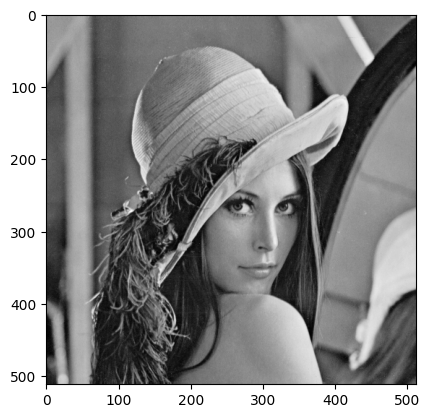

In [3]:
import matplotlib.pyplot as plt
plt.imshow(lena_gray, cmap='gray')

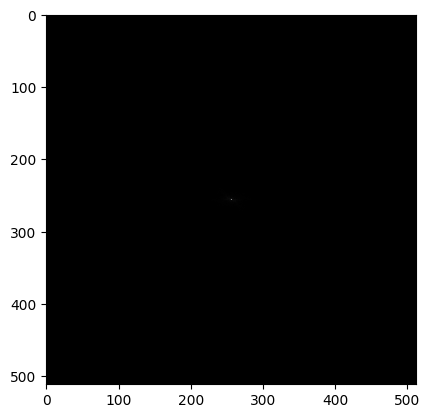

In [4]:
spectrum = np.abs(fftshift(fft2(lena_gray)))
plt.imshow(spectrum, cmap='gray')

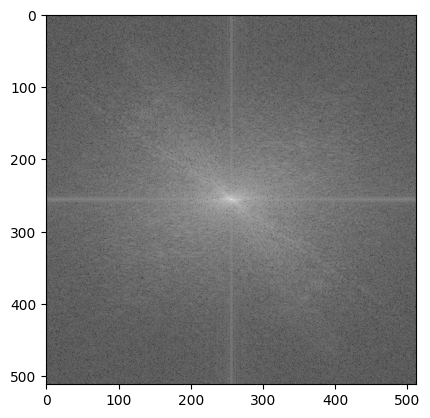

In [5]:
plt.imshow(np.log2(1+abs(spectrum)), cmap='gray')

In [6]:
image_quality_measure(lena_gray)

(np.float64(32518586.0), np.int64(4775), np.float64(0.018215179443359375))

Este valor coincide con el del trabajo publicado, es decir que nuestro algoritmo está implementado correctamente.
Sin embargo, vemos que cuando se quiere realizar la estimación del espectro, es distinta a la que se muestra en el paper. Esto puede ser debido a que se utilizó otra imagen de lena (podría ser de menor dimensión) o se realizó una estimación espectral con algun tipo de filtro adicional. 

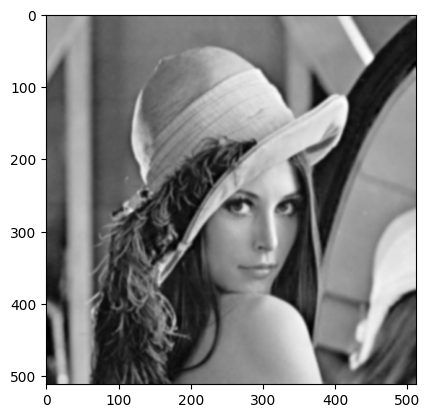

In [7]:
filtered_image = cv2.GaussianBlur(lena_gray, (7,7), 0)
plt.imshow(filtered_image, cmap='gray')

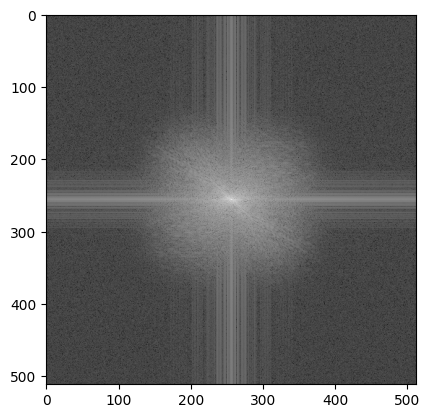

In [8]:
plt.imshow(np.log(1+np.abs(fftshift(fft2(filtered_image)))), cmap='gray')

In [9]:
image_quality_measure(filtered_image)

(np.float64(32518565.0), np.int64(3491), np.float64(0.013317108154296875))

Aquí vemos que cuando se aplica un GaussianBlur, la métrica disminuye, lo cual también es un comportamiento esperado.

In [78]:
import cv2
video = cv2.VideoCapture('focus_video.MOV')

In [79]:
def store_frames(vid):
    count = 0
    success = 1
    while success: 
        success, image = vid.read() 
        cv2.imwrite(f'frames/frame-{count:03}.jpg', image) 
        count += 1

In [83]:
# solo se necesita una vez, con la carpeta 'frames' creada, sino no funciona
# store_frames(video)

In [90]:
import os
frame_paths = list(map(lambda x: f'frames/{x}',sorted(os.listdir('frames'))))
frame_paths[:5]

['frames/frame-000.jpg',
 'frames/frame-001.jpg',
 'frames/frame-002.jpg',
 'frames/frame-003.jpg',
 'frames/frame-004.jpg']

In [110]:
metrics = [image_quality_measure(cv2.cvtColor(cv2.imread(frame), cv2.COLOR_BGR2GRAY)) for frame in frame_paths]

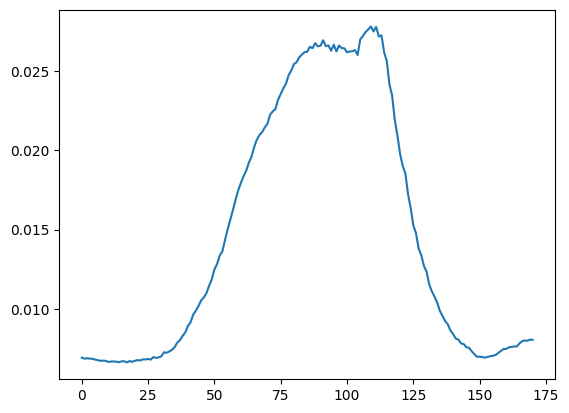

In [111]:
plt.plot(metrics)